In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import numpy as np
import os,glob,struct,shutil,copy
import xarray as xr
import pandas as pd
import seaborn as sns
import datetime as dt
from parflow import Run
from matplotlib import pyplot as plt
from parflow import read_pfb, read_pfb_sequence, ParflowBinaryReader

In [2]:
root_dir="/home/halidoua/PROJETS_2/Dossier_Prof//"
forc_dir="/home/halidoua/PROJETS_2/Dossier_Prof//Forcings/"

In [3]:
hill = Run.from_definition(root_dir+'hil_goudel.pfidb')

 => Error during CLM import - CLM specific key have been skipped


In [4]:
wdir = root_dir+'results_simulations/'

#Access the header: 
with ParflowBinaryReader(glob.glob(wdir+'*.press.00000.pfb')[0]) as s: h = s.header

In [5]:
def read_and_process_pf_outputs(wdir,date_start="2006-01-01"):
    # read header
    with ParflowBinaryReader(glob.glob(wdir+'*.press.00000.pfb')[0]) as s: h = s.header
    print(h)
    
    # get z
    var_dz = read_pfb(glob.glob(wdir+'*mult*.pfb')[0])
    var_dz_vec = var_dz[:,0,0]
    var_dz_vec = var_dz_vec[::-1]
    dz = var_dz_vec * h['dz']
    z = np.cumsum(dz) - var_dz_vec* h['dz']/2 
    
    # get pressure (pop(0) skips initial condition)
    files = np.sort(glob.glob(wdir+'*.press.*.pfb'))[1::]
    press = read_pfb_sequence(files)
    
    # get saturation
    files = np.sort(glob.glob(wdir+'*.satur.*.pfb'))[1::]
    satur = read_pfb_sequence(files)
    
    # get evaptranssum
    files = np.sort(glob.glob(wdir+'*.evaptranssum.*.pfb'))
    evaptranssum = read_pfb_sequence(files)
        
    # get overlandsum
    files = np.sort(glob.glob(wdir+'*.overlandsum.*.pfb'))
    overlandsum = read_pfb_sequence(files)
        
    # create dataset
    ds = xr.Dataset({"press": (("time","z","y"), press[:,::-1,:,0]),
                    "satur": (("time","z","y"), satur[:,::-1,:,0]),
                    "evaptranssum": (("time","z","y"), evaptranssum[:,::-1,:,0]),
                    "overlandsum":(("time","y"), overlandsum[:,0,:,0]),
                    'vdz': (("z","y"),var_dz[::-1,:,0])},
        coords={"x":np.arange(start = h['x'],stop = h['x']+h['nx']*h['dx'],step=h['dx']),
            "y":np.arange(start = h['y'],stop = h['y']+h['ny']*h['dy'],step=h['dy']),
            "z":-z, 
            "time": pd.date_range(date_start, periods=len(files)),
            "reference_time": pd.Timestamp(date_start)})

    # add WTD:
    ds = ds.assign(WTD = z[-1] - ds.press.isel(z=-1))

    # add auxiliary variables:
    ds = ds.assign(poro=(("z","y"),read_pfb(glob.glob(wdir+'*poro*.pfb')[0])[::-1,:,0]))
    ds = ds.assign(specstor=(("z","y"),read_pfb(glob.glob(wdir+'*specific*.pfb')[0])[::-1,:,0]))    

    # compute storage:
    ds = ds.assign(storage_cbyc=lambda x: h['dx']*h['dy']*h['dz']*x.satur*x.vdz*x.poro + \
                                        h['dx']*h['dy']*h['dz']*x.vdz*x.specstor*x.satur*x.press + \
                                        xr.where((x.z==x.z[0]) & (x.press>0),h['dx']*h['dy']*x.press,0))
    ds = ds.assign(storage=lambda x: x.storage_cbyc.sum(dim=('z')))

    ds = ds.assign(soil_moisture = lambda x: x.satur*x.poro)
    
    ds.press.attrs['units']='m'
    ds.satur.attrs['units']='m3/m3'
    ds.evaptranssum.attrs['units']='m3/PFtimestep'
    ds.overlandsum.attrs['units']='m3/PFtimestep' 
    ds.storage.attrs['units']='m3'
    ds.storage_cbyc.attrs['units']='m3'  
    ds.y.attrs['units']='meters'
    ds.z.attrs['units']='meters'
    return ds

In [6]:
ds1 = read_and_process_pf_outputs(wdir)

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 52, 'nz': 25, 'dx': 100.0, 'dy': 100.0, 'dz': 2.0, 'n_subgrids': 2, 'p': 1, 'q': 2, 'r': 1}


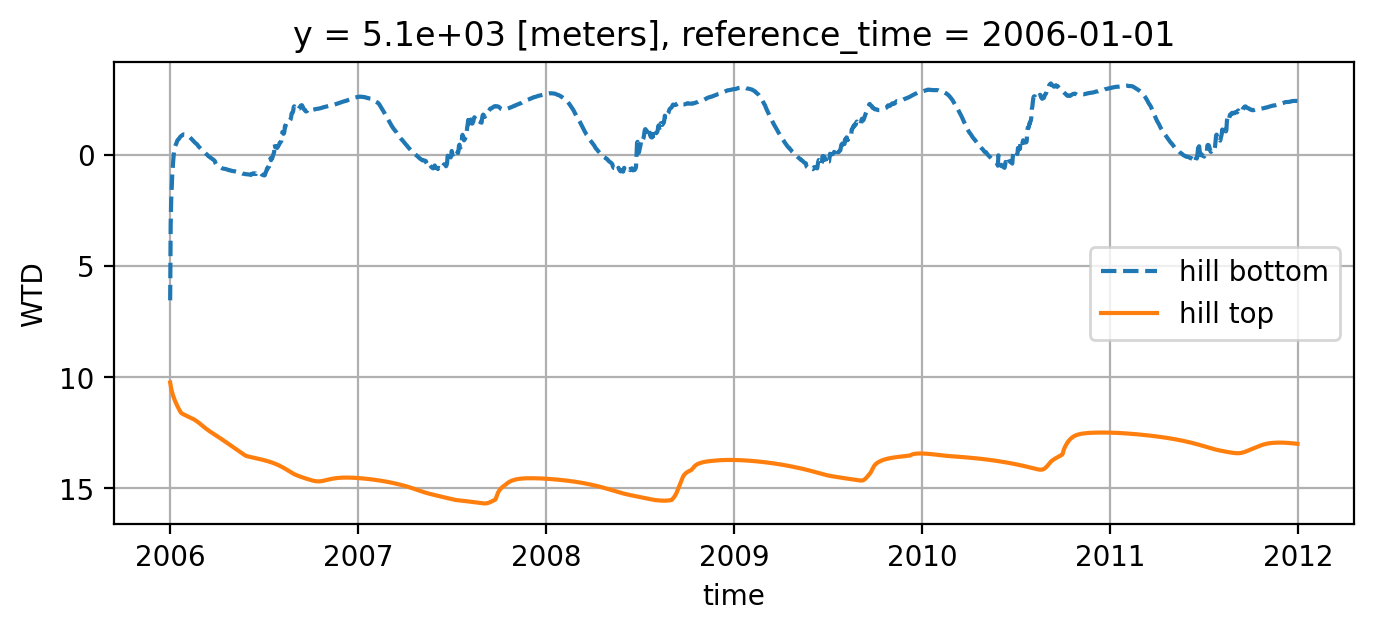

In [7]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,3), dpi=200)
ds1.WTD.isel(y=0).plot(label='hill bottom',ls='--')
ds1.WTD.isel(y=51).plot(label='hill top')
plt.gca().legend()
plt.gca().invert_yaxis()
plt.grid()

In [8]:
# Creation d'un dataframe avec les niveaux des nappes pour les 5 premieres maille
all_data=pd.DataFrame()
for i in range(5):
    current=ds1.WTD.isel(y=i).to_dataframe()
    current=current.drop(['reference_time', 'y'], axis=1)
    current=current.rename(columns={'WTD':'WTD'+str(i)})
    all_data=pd.concat([all_data,current], axis=1)
all_data.tail()

WTD0      WTD1      WTD2      WTD3      WTD4
time                                                        
2011-12-27 -2.447933 -0.964037 -0.212261  0.229657  1.044236
2011-12-28 -2.444102 -0.962477 -0.208970  0.235295  1.045163
2011-12-29 -2.440068 -0.960936 -0.207942  0.238379  1.046847
2011-12-30 -2.440126 -0.959600 -0.203565  0.242900  1.048861
2011-12-31 -2.438398 -0.960374 -0.209394  0.232477  1.047846

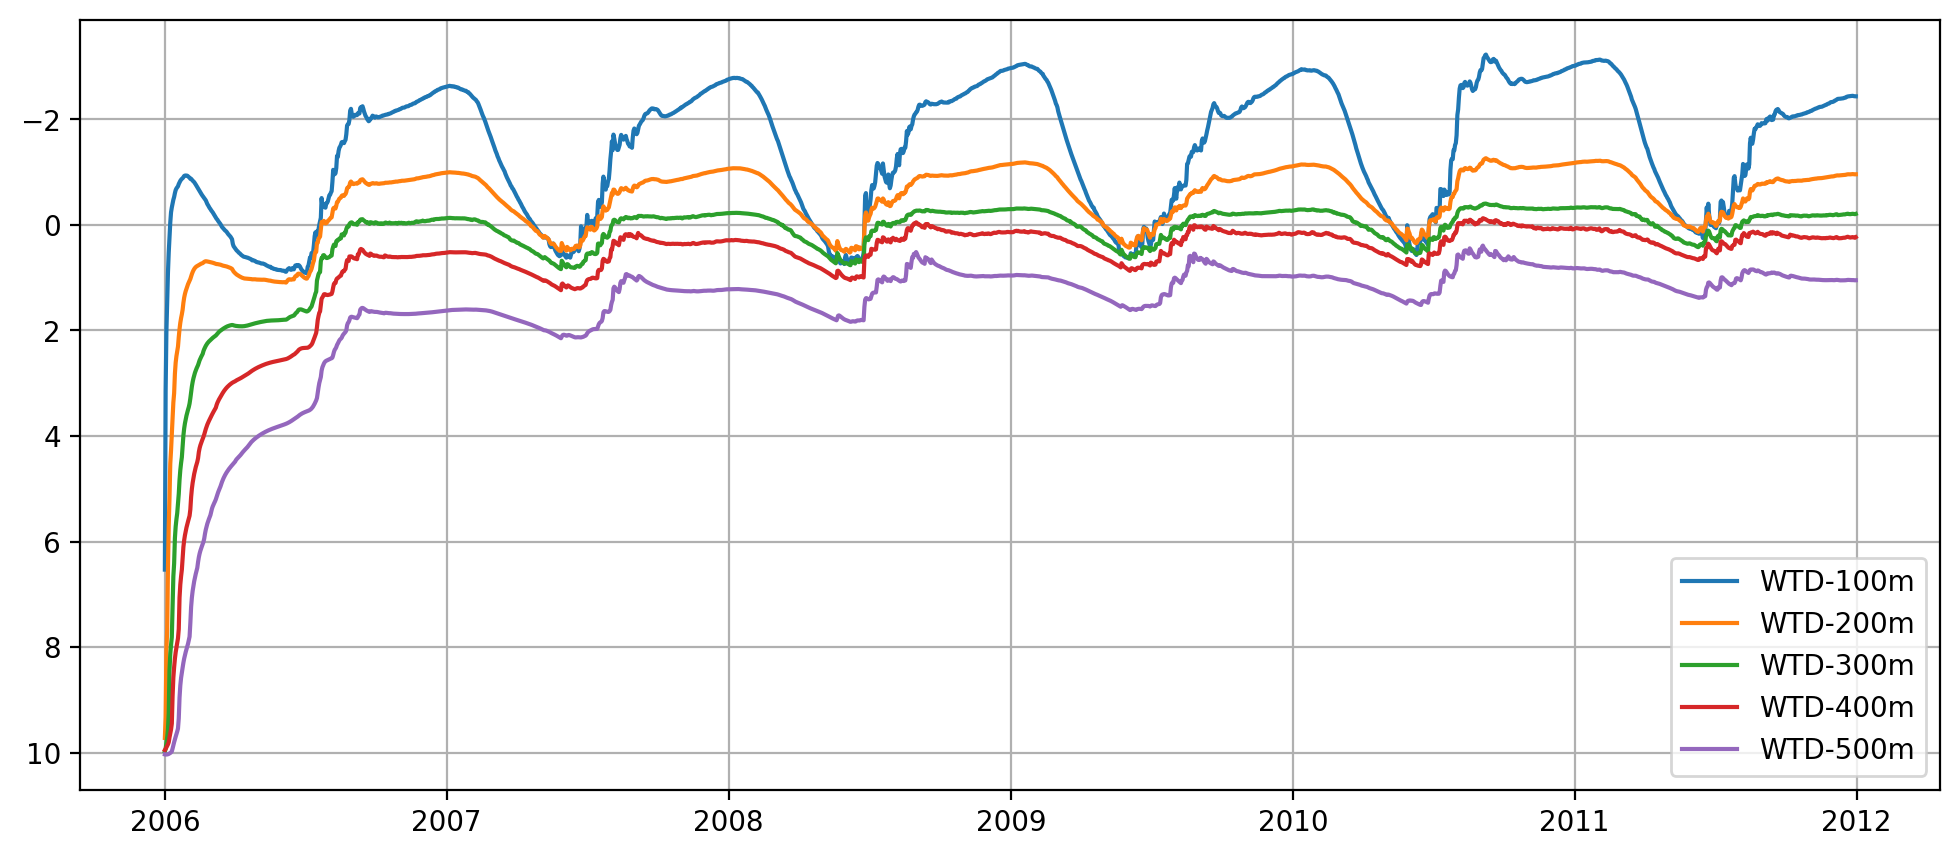

In [9]:
# Niveau des nappes pour les 5 premieres mailles
fig, ax=plt.subplots(1, figsize=(12,5), dpi=200)
ax.plot(all_data.index, all_data['WTD0'], label='WTD-100m')
ax.plot(all_data.index, all_data['WTD1'], label='WTD-200m')
ax.plot(all_data.index, all_data['WTD2'], label='WTD-300m')
ax.plot(all_data.index, all_data['WTD3'], label='WTD-400m')
ax.plot(all_data.index, all_data['WTD4'], label='WTD-500m')
plt.gca().invert_yaxis()
plt.legend()
plt.grid()

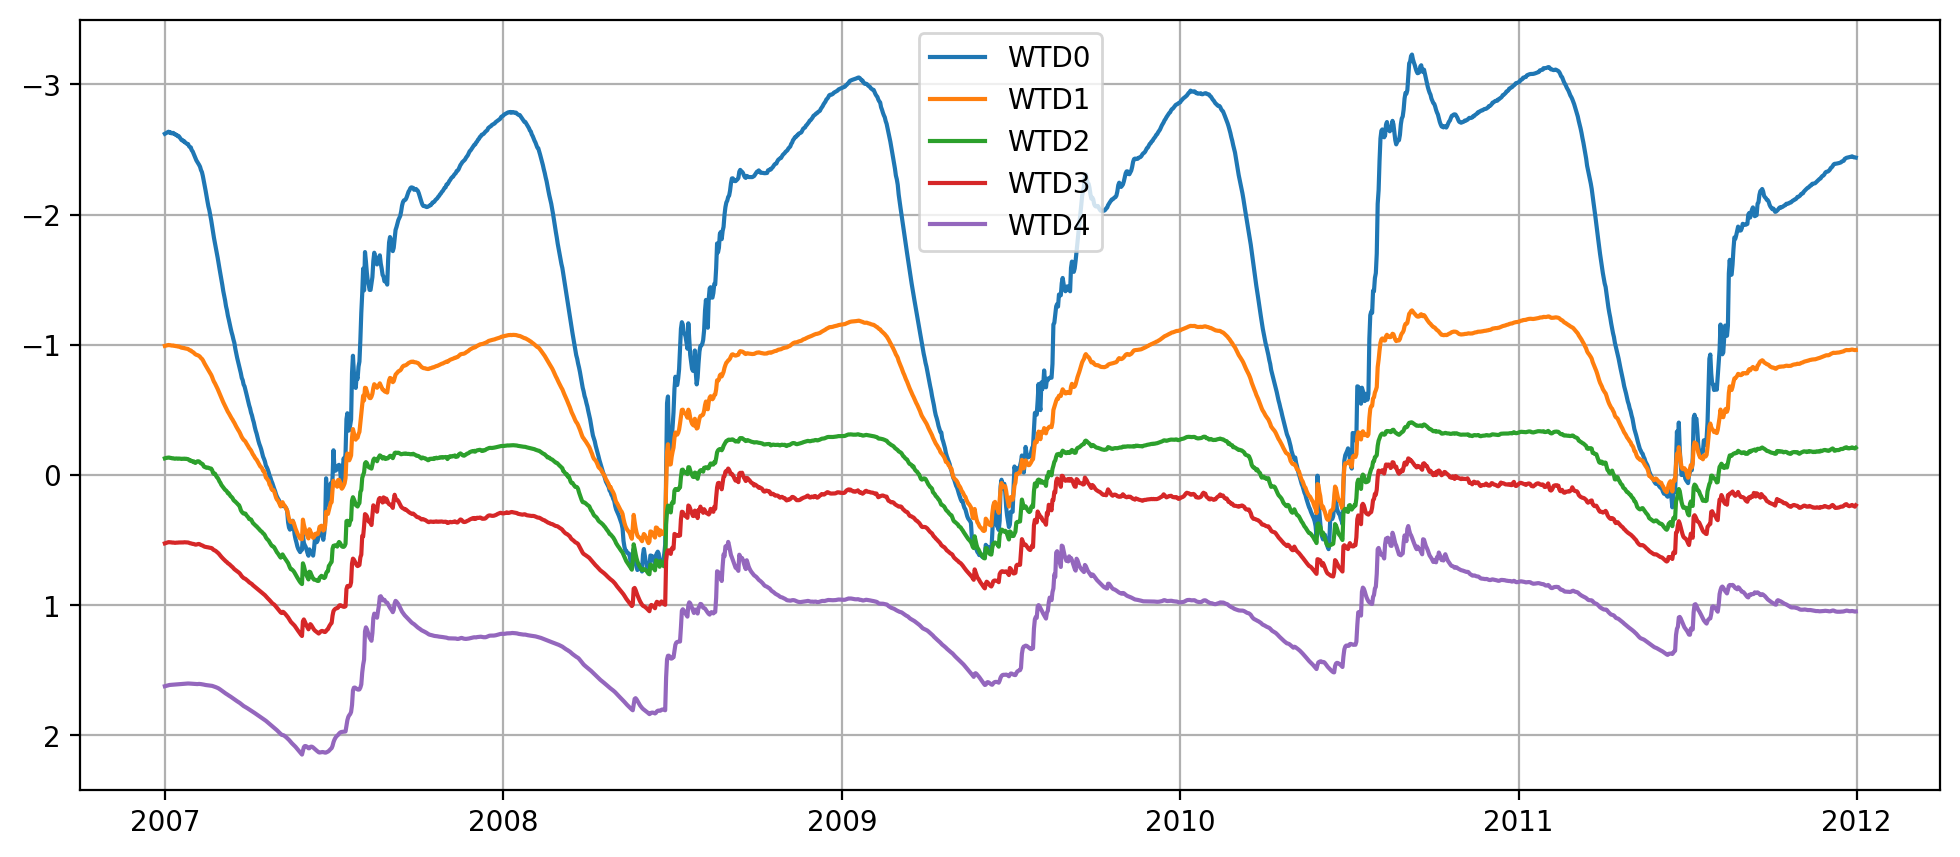

In [10]:
# Niveau des nappes pour les 5 premieres mailles sans l'année 2006
d07=all_data.loc['2007':'2011']
fig, ax=plt.subplots(1, figsize=(12,5), dpi=200)
plt.gca().invert_yaxis()
for i in range(5):
    #ax.plot(all_data.index, all_data['WTD'+str(i)], label='WTD'+str(i))
    ax.plot(d07.index, d07['WTD'+str(i)], label='WTD'+str(i))
plt.legend()
plt.grid()

In [11]:
#Hauteurs du Fleuve
df=pd.read_excel('/home/halidoua/Data_Niger_river/Hauteurs_2006_2012.xlsx', index_col='Date',
                 parse_dates=True)

dd=df.loc['2007':'2011'][['H']]

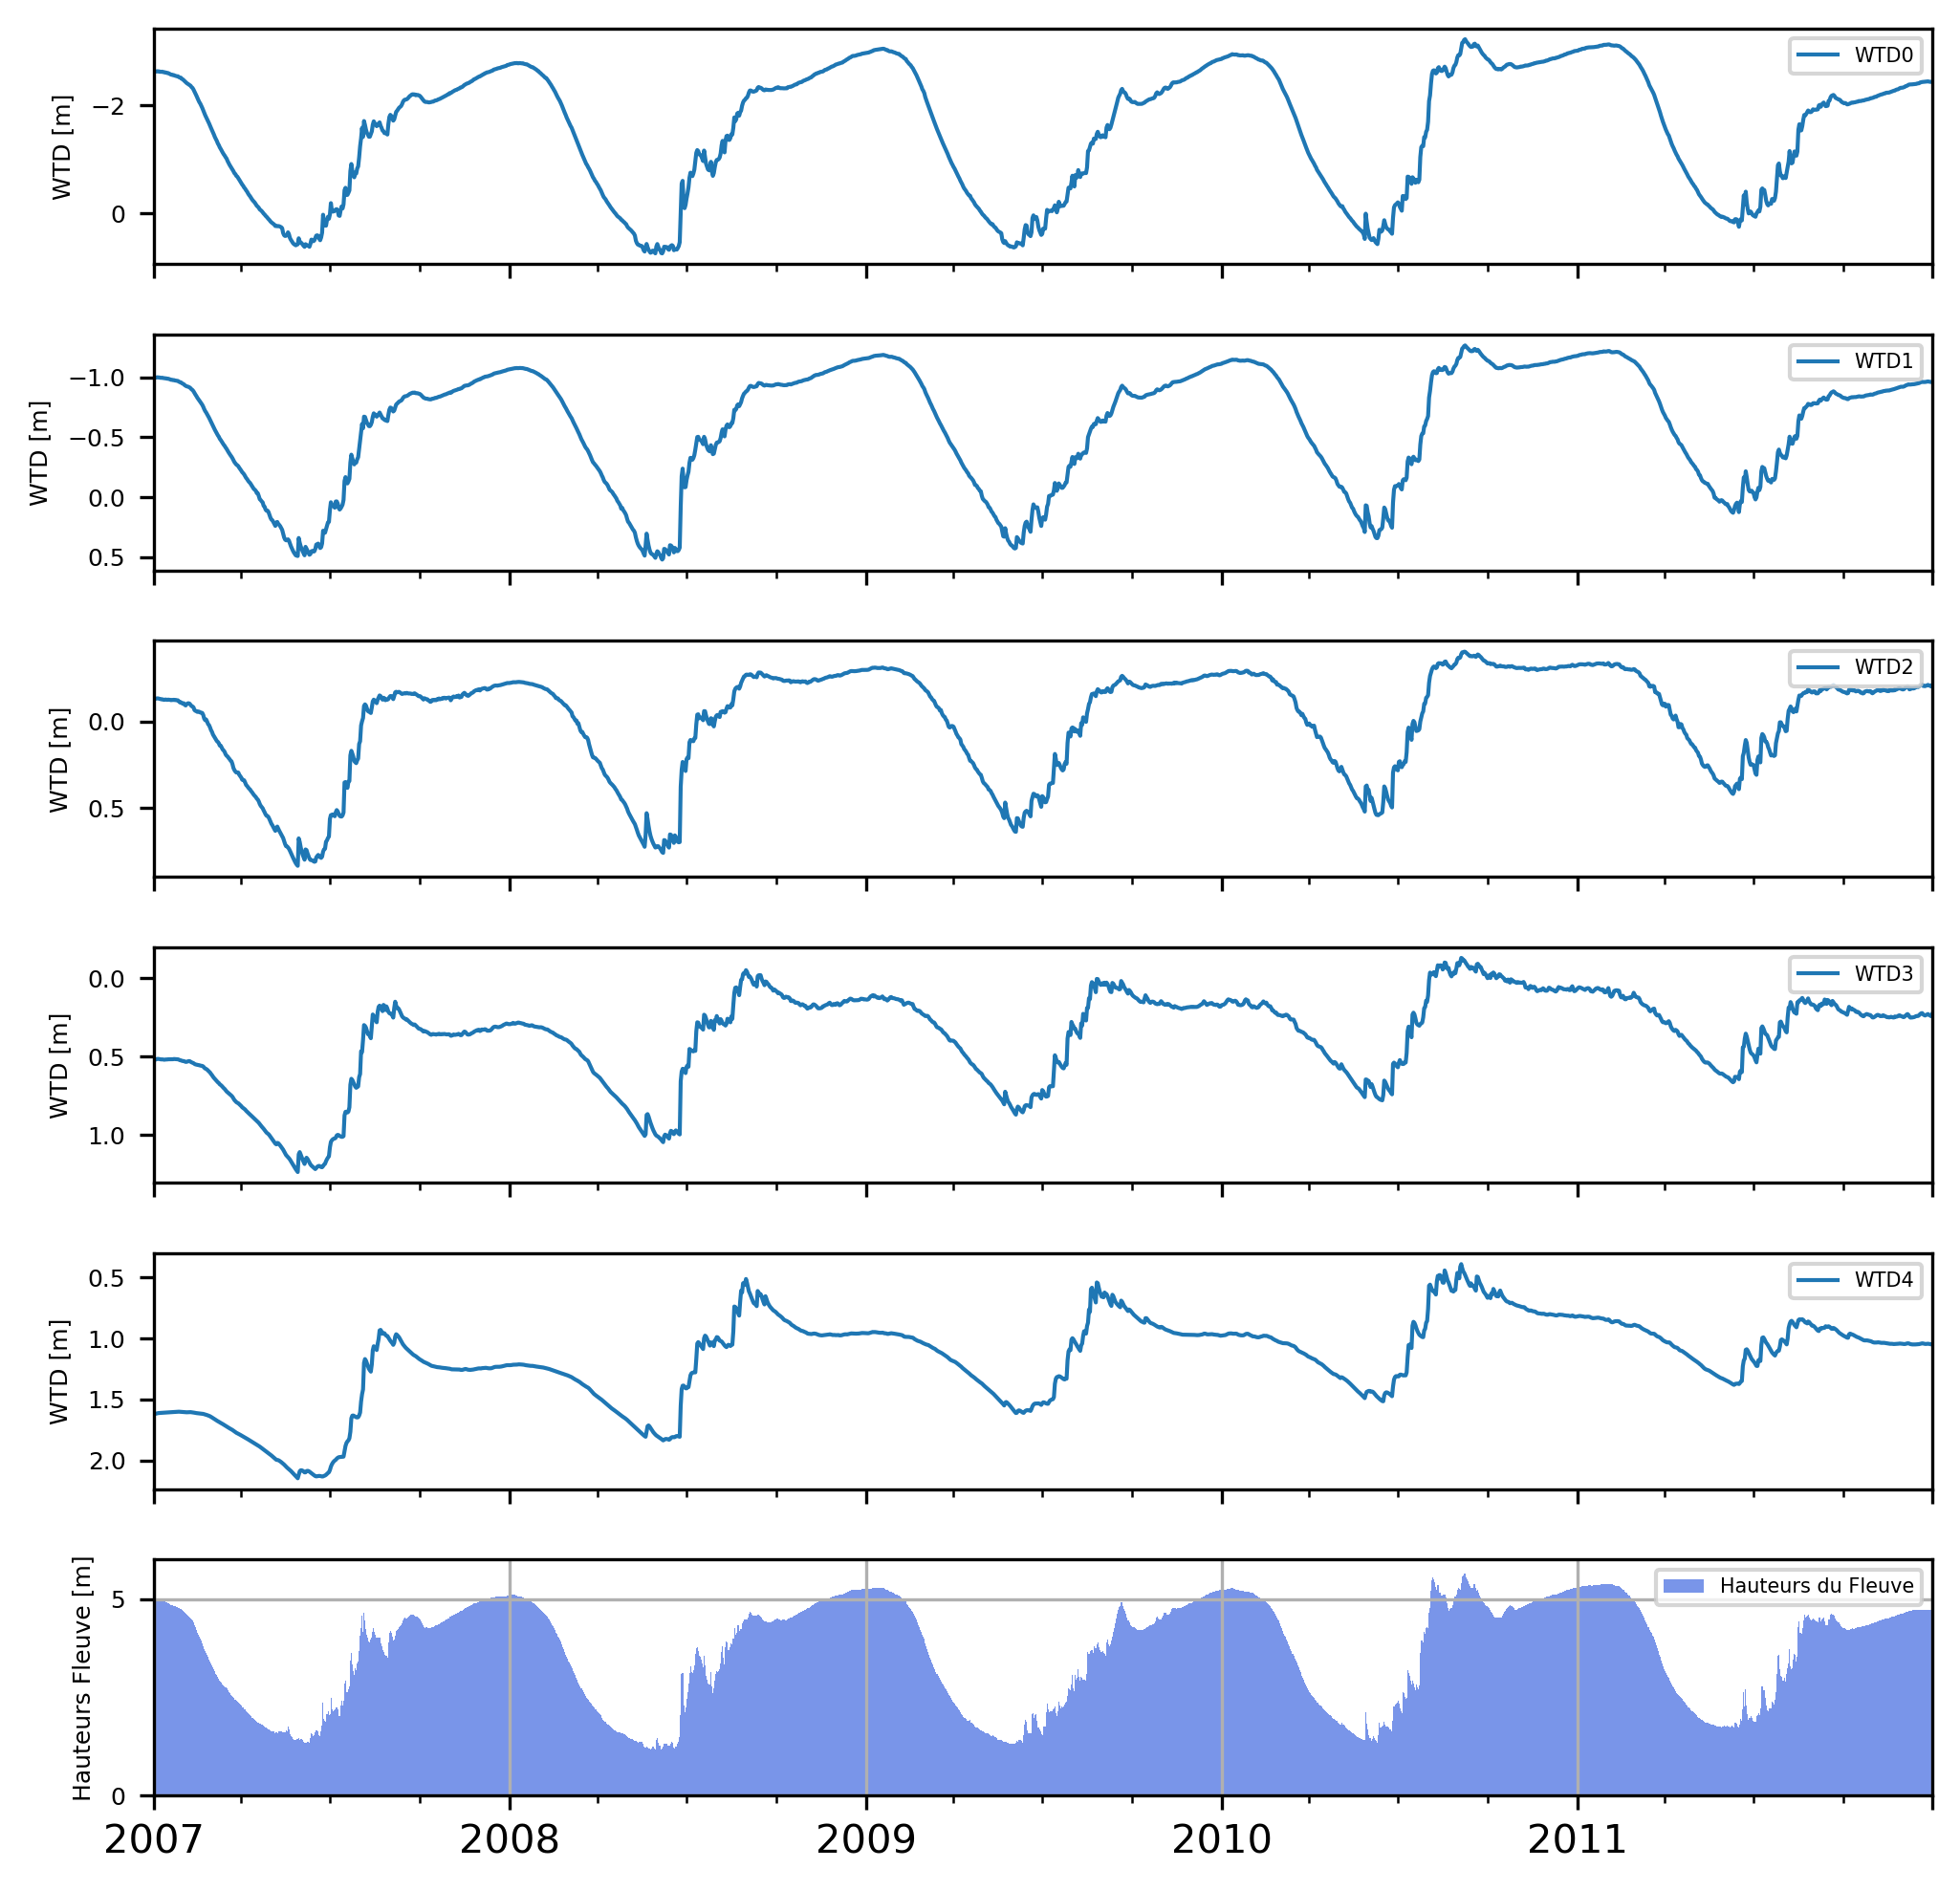

In [12]:
fig, ax=plt.subplots(6, figsize=(8,8), dpi=300, sharex=True)
fig.subplots_adjust(wspace=0.2, hspace=0.3)
for i in range(5):
    ax[i]=d07.loc['2007':'2011']['WTD'+str(i)].plot(ax=ax[i], label='WTD'+str(i), lw=1)
    ax[i].invert_yaxis()
    ax[i].legend(loc=1, fontsize=5)
    ax[i].set_ylabel('WTD [m]', fontsize=6)
    ax[i].tick_params(axis='x', labelsize=6)
    ax[i].tick_params(axis='y', labelsize=6)
plt.bar(dd.index, dd['H'], label='Hauteurs du Fleuve',width=1, color='royalblue', alpha=0.7)
plt.legend(fontsize=5)
plt.ylabel('Hauteurs Fleuve [m]', fontsize=6)
plt.ylim(0,6)
plt.yticks(fontsize=6)
plt.grid()
#plt.savefig('WTD_bas_versant_ind16.png', dpi=300)

In [14]:
all_data2=pd.DataFrame()
for i in range(47,52):
    current=ds1.WTD.isel(y=i).to_dataframe()
    current=current.drop(['reference_time', 'y'], axis=1)
    current=current.rename(columns={'WTD':'WTD'+str(i)})
    all_data2=pd.concat([all_data2,current], axis=1)
all_data2.head()

WTD47      WTD48      WTD49      WTD50      WTD51
time                                                            
2006-01-01  9.991745   9.999105  10.003180  10.031471  10.232503
2006-01-02  9.990494   9.999807  10.013685  10.082390  10.385025
2006-01-03  9.990659  10.002742  10.030304  10.138569  10.507589
2006-01-04  9.991466  10.008106  10.051102  10.194610  10.610120
2006-01-05  9.992839  10.015567  10.074420  10.248442  10.698743

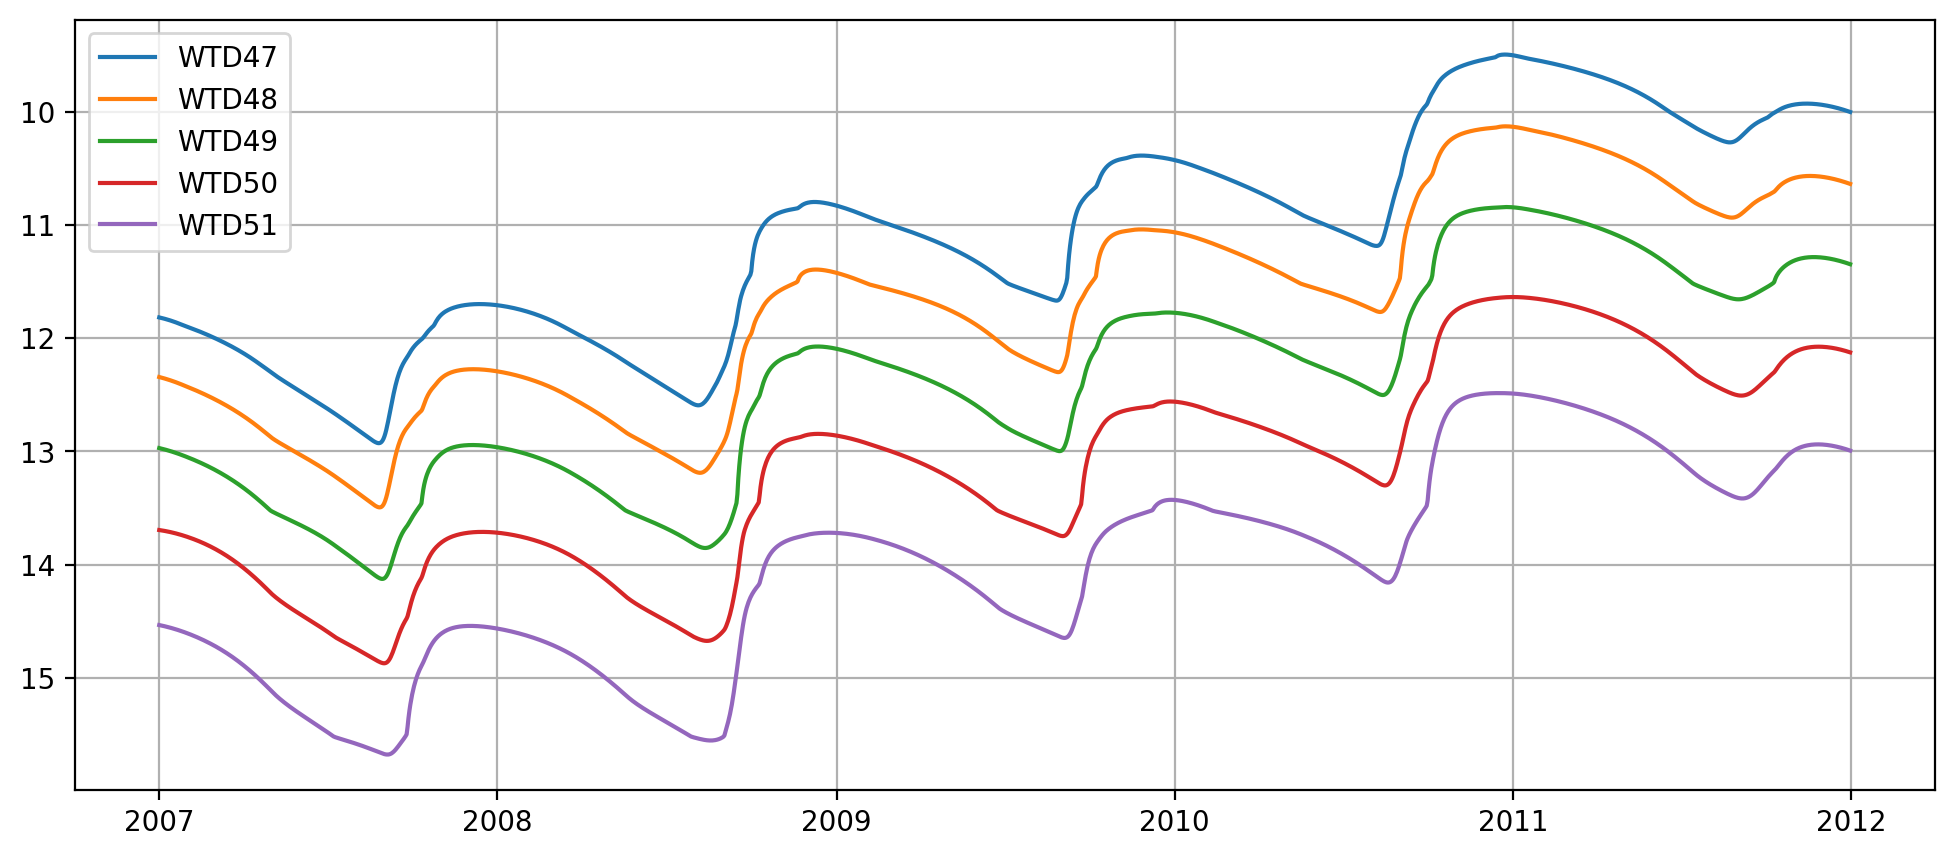

In [15]:
# Niveau des nappes pour les 5 dernieres mailles sans l'année 2006
dh=all_data2.loc['2007':'2011']
fig, ax=plt.subplots(1, figsize=(12,5), dpi=200)
plt.gca().invert_yaxis()
for i in range(47,52):
    ax.plot(dh.index, dh['WTD'+str(i)], label='WTD'+str(i))
plt.legend()
plt.grid()

(array([0., 2., 4., 6.]),
 [Text(0, 0.0, '0'), Text(0, 2.0, '2'), Text(0, 4.0, '4'), Text(0, 6.0, '6')])

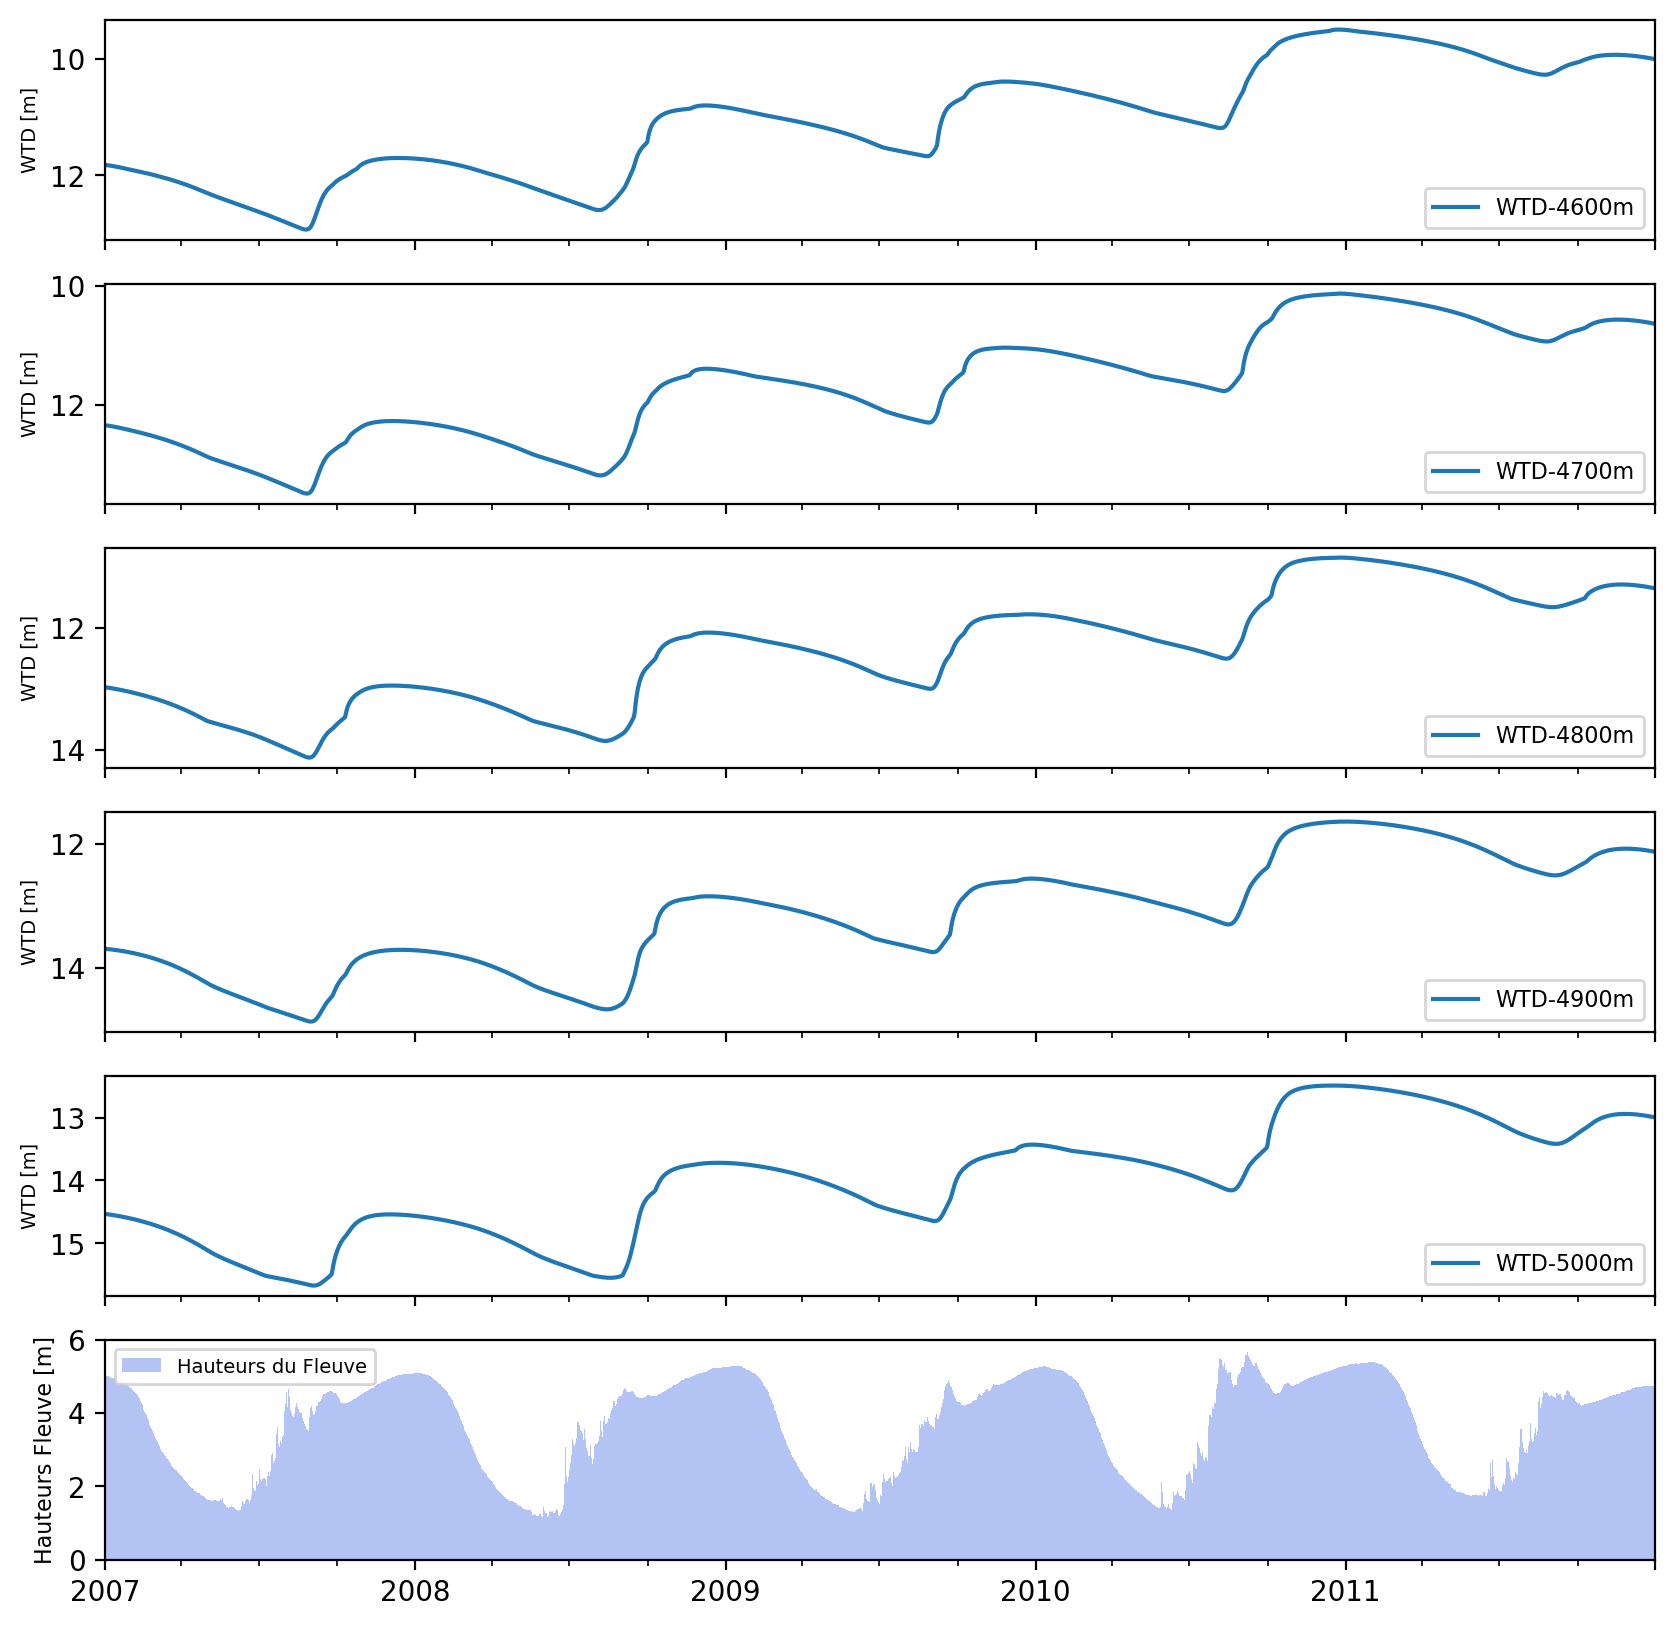

In [16]:
fig, ax=plt.subplots(6, figsize=(10,10), dpi=200, sharex=True)
ax[0]=dh.loc['2007':'2011']['WTD47'].plot(ax=ax[0],label='WTD-4600m')
ax[1]=dh.loc['2007':'2011']['WTD48'].plot(ax=ax[1],label='WTD-4700m')
ax[2]=dh.loc['2007':'2011']['WTD49'].plot(ax=ax[2],label='WTD-4800m')
ax[3]=dh.loc['2007':'2011']['WTD50'].plot(ax=ax[3],label='WTD-4900m')
ax[4]=dh.loc['2007':'2011']['WTD51'].plot(ax=ax[4],label='WTD-5000m')
for i in range(5):
    ax[i].invert_yaxis()
    ax[i].legend(loc=4, fontsize=8)
    ax[i].set_ylabel('WTD [m]', fontsize=7)
plt.bar(dd.index, dd['H'], label='Hauteurs du Fleuve',width=1, color='royalblue', alpha=0.4)
plt.legend(fontsize=7)
plt.ylabel('Hauteurs Fleuve [m]', fontsize=8)
plt.ylim(0,6)
plt.yticks()
#plt.savefig('WTD_haut_versant_ind16.png', dpi=300)

In [1]:
def calculate_OVFLOW(width,manning,slope,h):
    """
    simple function which return the overland flux from one cell to another across one cell
    """
    return (width/manning)*(slope**0.5)*h**(5./3.)


def calculate_runoff_from_press(htop,slopex,slopey,dx,dy,m):
    """
    compute runoff at single location
    htop dim is time
    """
    Sy = np.abs(slopey)
    Sx = np.abs(slopex)
    return np.where(htop>0,np.abs(calculate_OVFLOW(dy,m,Sx,htop))+np.abs(calculate_OVFLOW(dx,m,Sy,htop)),0)

def read_clm_outputs(wdir,date_start="2006-01-01"):
    # read header
    with ParflowBinaryReader(glob.glob(wdir+'*.press.00000.pfb')[0]) as s: h = s.header
    print(h)    
    
    # get z
    var_dz = read_pfb(glob.glob(wdir+'*mult*.pfb')[0])
    var_dz_vec = var_dz[:,0,0]
    var_dz_vec = var_dz_vec[::-1]
    dz = var_dz_vec * h['dz']
    z = np.cumsum(dz) - var_dz_vec/2 
    
    files = np.sort(glob.glob(wdir+'*.clm_output.*.pfb'))
    clms = read_pfb_sequence(files)
    # create dataset
    ds = xr.Dataset({"lh_tot": (("time","y"), clms[:,0,:,0]),
                    "lwrad_out": (("time","y"), clms[:,1,:,0]),
                    "sh_tot": (("time","y"), clms[:,2,:,0]),
                    "soil_grnd": (("time","y"), clms[:,3,:,0]),
                    "evap_tot": (("time","y"), clms[:,4,:,0]*60*60),
                    "evap_grnd": (("time","y"), clms[:,5,:,0]*60*60),
                    "evap_soi": (("time","y"), clms[:,6,:,0]*60*60),
                    "evap_veg": (("time","y"), clms[:,7,:,0]*60*60),
                    "tran_veg": (("time","y"), clms[:,8,:,0]*60*60),
                    "infl": (("time","y"), clms[:,9,:,0]*60*60),
                    "swe_out": (("time","y"), clms[:,10,:,0]),
                    "t_grnd": (("time","y"), clms[:,11,:,0]),
                    "htop": (("time","y"), clms[:,12,:,0])},

        coords={
            "y":np.arange(start = h['y'],stop = h['y']+h['ny']*h['dy'],step=h['dy']),
                    "z":-z,
            "time": pd.date_range(date_start, periods=len(files),freq='1H'),
            "reference_time": pd.Timestamp(date_start)})

    ds = ds.assign(slopex=(("y"),read_pfb(glob.glob(wdir+'*slope_x*.pfb')[0])[0,:,0]))
    ds = ds.assign(slopey=(("y"),read_pfb(glob.glob(wdir+'*slope_y*.pfb')[0])[0,:,0]))

    ds.lh_tot.attrs['units']='$W/m^2$'
    ds.lwrad_out.attrs['units']='$W/m^2$'
    ds.sh_tot.attrs['units']='$W/m^2$'
    ds.soil_grnd.attrs['units']='$W/m^2$'
    ds.evap_tot.attrs['units']='mm/h'
    ds.evap_grnd.attrs['units']='mm/h'
    ds.evap_soi.attrs['units']='mm/h'
    ds.evap_veg.attrs['units']='mm/h'
    ds.tran_veg.attrs['units']='mm/h'
    ds.infl.attrs['units']='mm/h'
    ds.swe_out.attrs['units']='mm'
    ds.t_grnd.attrs['units']='K'
    ds.htop.attrs['units']='m'

    ds.y.attrs['units']='meters'
    return ds

In [11]:
#dc1 = read_clm_outputs(root_dir+'results_benchmark/')
dc1 = read_clm_outputs(wdir)

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 52, 'nz': 25, 'dx': 100.0, 'dy': 100.0, 'dz': 2.0, 'n_subgrids': 2, 'p': 1, 'q': 2, 'r': 1}


In [12]:
dc1 = dc1.assign(slopex=(("y"),read_pfb(glob.glob(wdir+'*slope_x*.pfb')[0])[0,:,0]))
dc1 = dc1.assign(slopey=(("y"),read_pfb(glob.glob(wdir+'*slope_y*.pfb')[0])[0,:,0]))
dc1 = dc1.assign(mask=(("z","y","x"),read_pfb(glob.glob(wdir+'*mask*.pfb')[0])))

In [13]:
hill = Run.from_definition(wdir+'hil_goudel.pfidb')
manning = hill.Mannings.Geom.domain.Value
dc1 = dc1.assign(Q=lambda x: ('time',calculate_runoff_from_press(x.htop.data[:,0],
                                                         x.slopex.data[0],
                                                         x.slopey.data[0],
                                                         10,10,manning)))
dc1.Q.attrs['units']='m3/CLMtimestep'

In [14]:
dss=xr.open_dataset("/home/halidoua/PROJETS/Data_Evaluation/Evaluation2_data_wank.nc")

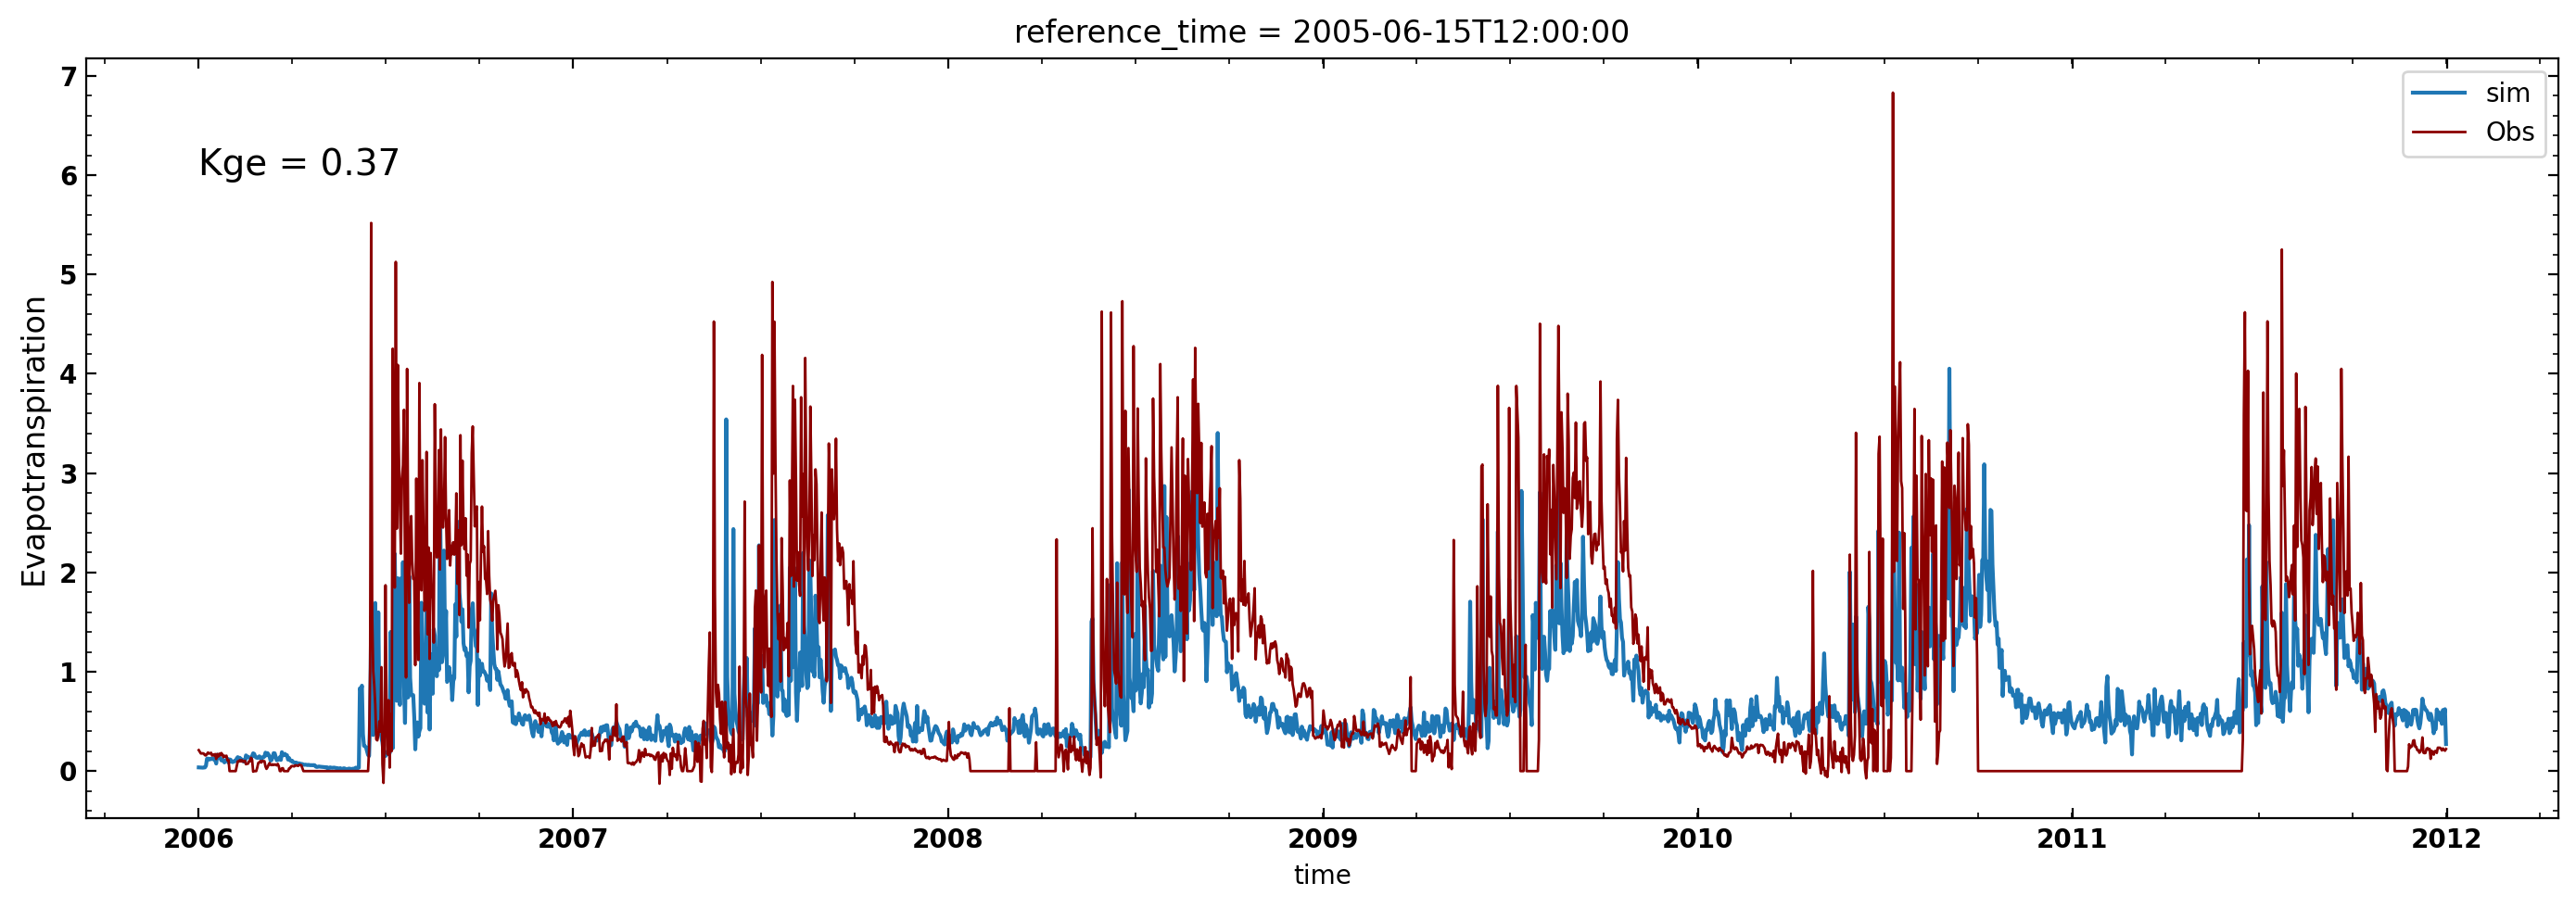

In [15]:
import hydroeval as he
fig, ax=plt.subplots(1, figsize=(14,5), dpi=200)
dc1.evap_tot.mean(dim='y').resample(time='D').sum().sel(time=slice('2006', '2011')).plot(label='sim')
dss.evap_tot.resample(time='D').sum().sel(time=slice('2006', '2011')).plot(label='Obs', lw=1, c='darkred')

sim=dc1.evap_tot.mean(dim='y').resample(time='D').sum().sel(time=slice('2006', '2011'))
obs=dss.evap_tot.resample(time='D').sum().sel(time=slice('2006', '2011'))
kge = float(np.round(he.evaluator(he.kge, sim, obs)[0],2))
plt.text(dt.datetime(2006,1, 1),6, f"Kge = {kge}", fontsize=14)
plt.ylabel('Evapotranspiration', fontsize=12)
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
ax.minorticks_on()
plt.tick_params(direction='in', which='minor', right=True, top=True, length=2)
plt.tick_params(direction='in', which='major', right=True, top=True, length=4)
plt.tight_layout()
plt.legend()

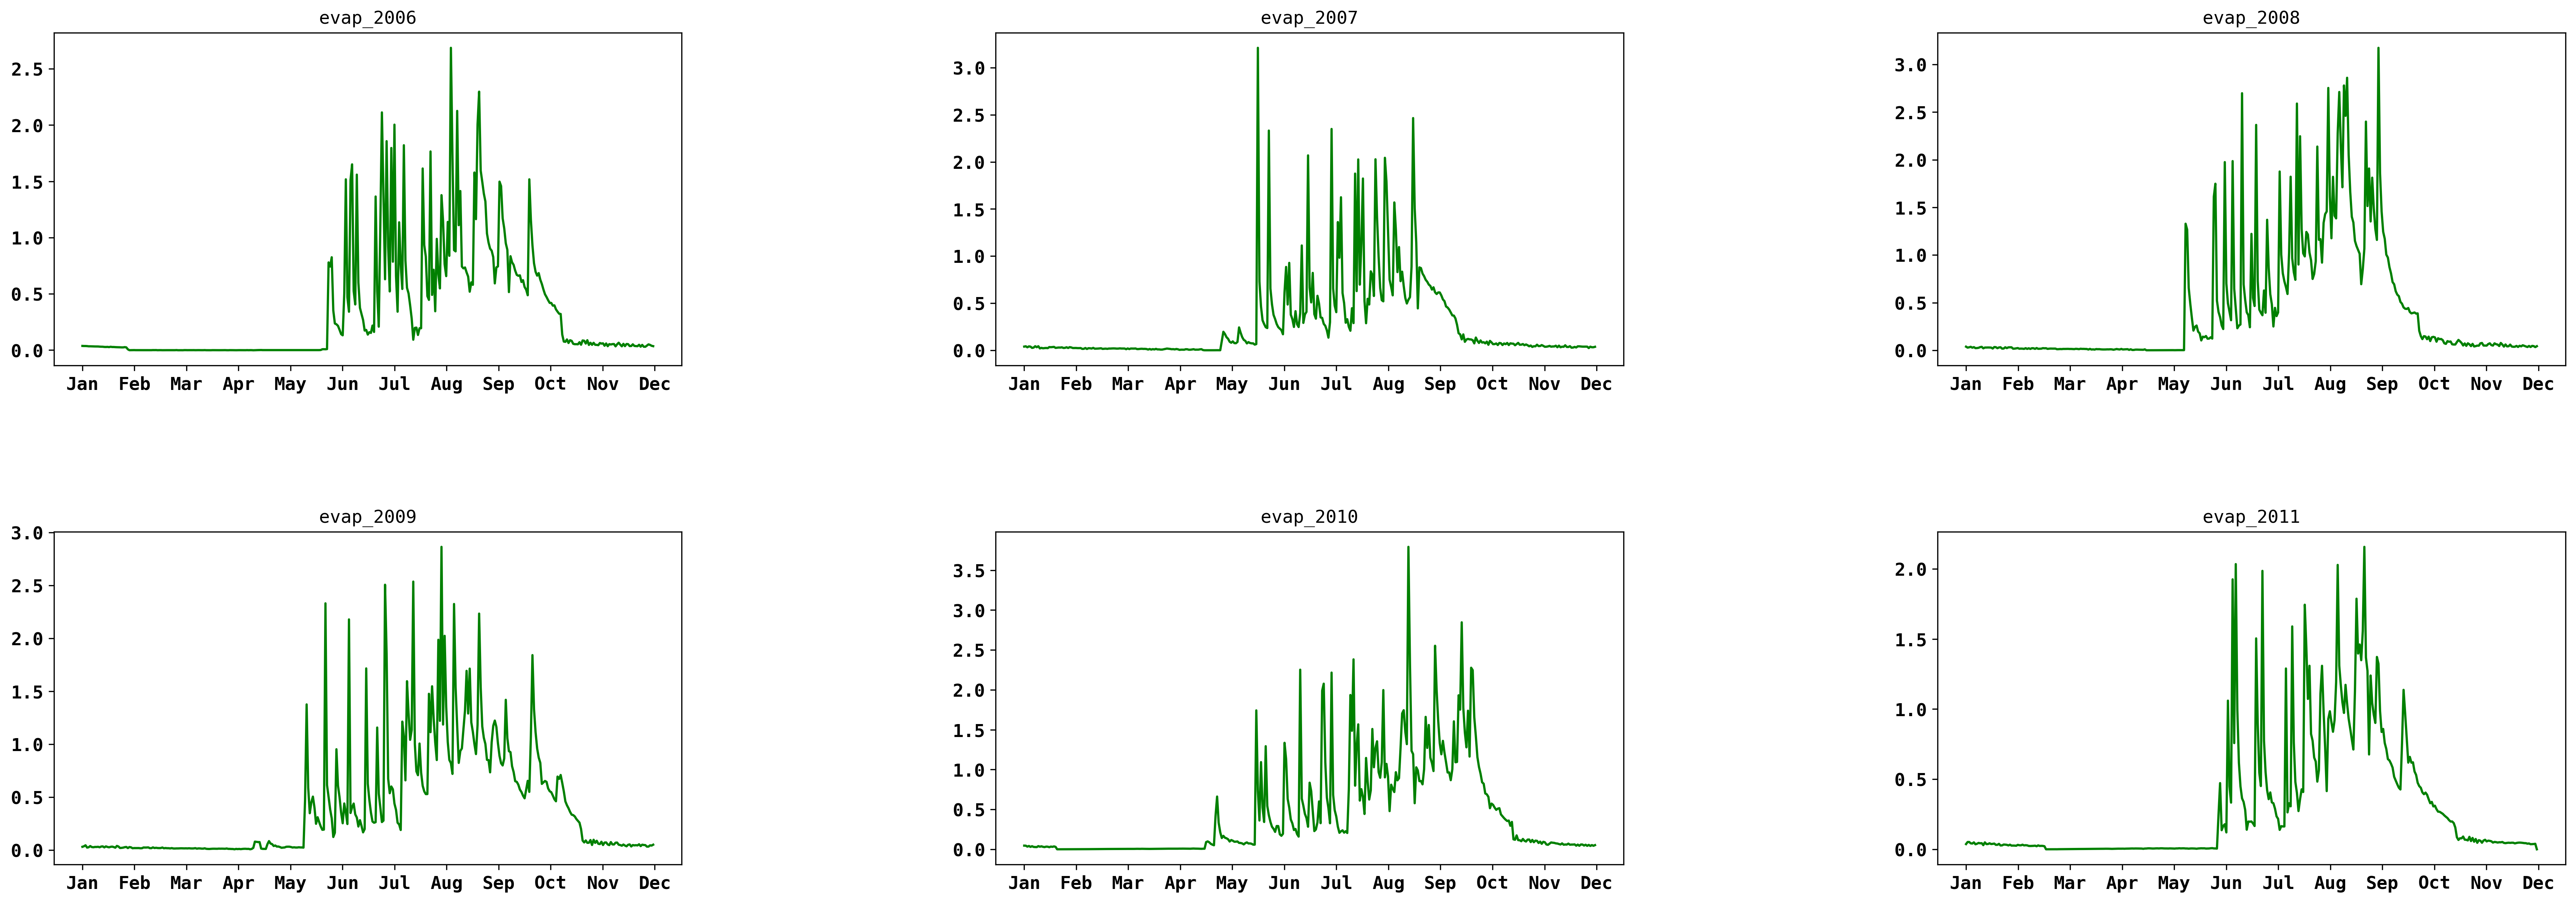

In [70]:
from matplotlib import rc

font_properties = {'family' : 'monospace',
  'weight' : 'bold',
  'size' : 10}
rc('font', **font_properties)
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)
fig, axes = plt.subplots(2,3, figsize=(30, 10), dpi=300)

for col, ax in zip(ETP.columns, axes.flatten()):
    #color= ['darkred' if i<0 else 'royalblue' for i in ETP[col]]
    ax.plot(ETP.index, ETP[col],color='green')
    plt.subplots_adjust(wspace=.5, hspace=.5)
    ax.set_title(col)
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.set_xticks(np.linspace(0,365,12), months);